In [1]:



# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn import svm
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


# Reading all the required dataset  #    


In [2]:

df_train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv')
df_test =  pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv')

# Target Dataset

In [3]:


sample = pd.read_csv('../input/tabular-playground-series-aug-2022/sample_submission.csv')

In [4]:
sample.columns  # To check what is it 

Index(['id', 'failure'], dtype='object')

In [5]:
df_train.shape,df_test.shape  # To check shape

((26570, 26), (20775, 25))

In [6]:
Y = df_train['failure'] # Target Variable is created

# Lets combine the dataset for better EDA

In [7]:

df_total = pd.concat([df_train,df_test])  # Better approach is together combine the data .....

In [8]:
df_total.columns # After combing check the data

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

In [9]:
df_total['failure'].value_counts() # hmmm Data imbalace for target

0.0    20921
1.0     5649
Name: failure, dtype: int64

In [10]:
df_total['product_code'].unique()  

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], dtype=object)

In [11]:
X= df_total.drop(['id','failure','product_code'],axis=1) # Drop kar detey hai inko 
# May be not so usefull in prediction

In [12]:
X.isnull().sum() # to check for null in the whole data

loading            473
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      710
measurement_4      947
measurement_5     1184
measurement_6     1420
measurement_7     1657
measurement_8     1894
measurement_9     2131
measurement_10    2367
measurement_11    2604
measurement_12    2841
measurement_13    3077
measurement_14    3314
measurement_15    3551
measurement_16    3788
measurement_17    4024
dtype: int64

In [13]:
X.info() # To check on data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47345 entries, 0 to 20774
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loading         46872 non-null  float64
 1   attribute_0     47345 non-null  object 
 2   attribute_1     47345 non-null  object 
 3   attribute_2     47345 non-null  int64  
 4   attribute_3     47345 non-null  int64  
 5   measurement_0   47345 non-null  int64  
 6   measurement_1   47345 non-null  int64  
 7   measurement_2   47345 non-null  int64  
 8   measurement_3   46635 non-null  float64
 9   measurement_4   46398 non-null  float64
 10  measurement_5   46161 non-null  float64
 11  measurement_6   45925 non-null  float64
 12  measurement_7   45688 non-null  float64
 13  measurement_8   45451 non-null  float64
 14  measurement_9   45214 non-null  float64
 15  measurement_10  44978 non-null  float64
 16  measurement_11  44741 non-null  float64
 17  measurement_12  44504 non-null 

# Preprocessing step

In [14]:
# From the above pre-processing we can see
# Custom function to take care of missing values in numeric and non numeric dataset
# Luxury terms are mostly skewed towards zero
# Lets pre-process the whole data set

from sklearn.base import TransformerMixin
import pandas as pd
import numpy as np

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
      
        return X.fillna(self.fill)

In [15]:
df_tr = pd.DataFrame(X)  # Function is called on whole dataset
df_final = DataFrameImputer().fit_transform(df_tr)

In [16]:
df_final.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47345 entries, 0 to 20774
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loading         47345 non-null  float64
 1   attribute_0     47345 non-null  object 
 2   attribute_1     47345 non-null  object 
 3   attribute_2     47345 non-null  int64  
 4   attribute_3     47345 non-null  int64  
 5   measurement_0   47345 non-null  int64  
 6   measurement_1   47345 non-null  int64  
 7   measurement_2   47345 non-null  int64  
 8   measurement_3   47345 non-null  float64
 9   measurement_4   47345 non-null  float64
 10  measurement_5   47345 non-null  float64
 11  measurement_6   47345 non-null  float64
 12  measurement_7   47345 non-null  float64
 13  measurement_8   47345 non-null  float64
 14  measurement_9   47345 non-null  float64
 15  measurement_10  47345 non-null  float64
 16  measurement_11  47345 non-null  float64
 17  measurement_12  47345 non-null 

In [17]:
# To check corelation

import seaborn as sns
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,1.000000,0.004305,-0.741200,0.558881,-0.253626,0.400206,0.000128,-0.005923,0.011313,-0.007001,0.008734,-0.011881,0.000437,0.001550,-0.029611,0.009524,-0.151220,-0.037559,-0.053744,0.083951,-0.059849,-0.000983,-0.007545
loading,0.004305,1.000000,-0.008208,-0.000756,-0.005578,0.002532,0.000303,-0.005203,-0.011792,-0.005599,0.007310,-0.001773,-0.002998,-0.007751,-0.007525,0.003594,-0.002407,0.006138,0.000120,-0.008087,-0.000633,0.000305,0.129089
attribute_2,-0.741200,-0.008208,1.000000,-0.538697,0.175387,-0.377971,0.030522,0.005849,-0.011797,0.006811,-0.002181,0.010338,-0.001717,-0.000098,-0.004953,0.094038,0.226756,0.049639,0.020921,-0.161242,0.035795,0.004729,0.006337
attribute_3,0.558881,-0.000756,-0.538697,1.000000,-0.370232,0.329233,0.013258,-0.002265,0.015470,-0.004034,0.000119,-0.008046,-0.006233,-0.002295,-0.100845,-0.025434,-0.132060,0.028472,-0.049711,0.187519,-0.061520,-0.001418,-0.019222
measurement_0,-0.253626,-0.005578,0.175387,-0.370232,1.000000,-0.255255,-0.083813,-0.004890,-0.006459,0.003304,0.003731,0.000669,-0.005037,0.009112,0.032779,0.001878,0.033496,-0.031527,0.021907,-0.055431,0.003025,0.003351,0.009646
measurement_1,0.400206,0.002532,-0.377971,0.329233,-0.255255,1.000000,0.005032,-0.008363,0.001535,-0.005587,-0.001562,-0.016977,0.000286,0.004529,0.011986,-0.035312,-0.084605,0.007523,-0.011471,0.060870,-0.004509,-0.004651,-0.010810
measurement_2,0.000128,0.000303,0.030522,0.013258,-0.083813,0.005032,1.000000,-0.002751,-0.009797,0.000241,-0.009157,0.002012,0.000591,0.001884,0.018695,-0.003877,-0.001808,0.029145,0.014623,0.000138,0.033088,-0.009596,0.015808
measurement_3,-0.005923,-0.005203,0.005849,-0.002265,-0.004890,-0.008363,-0.002751,1.000000,0.009573,0.009864,0.008322,0.006111,0.001286,0.008195,-0.004854,-0.004427,0.002445,0.005893,0.002150,-0.010986,-0.002164,0.080902,0.003577
measurement_4,0.011313,-0.011792,-0.011797,0.015470,-0.006459,0.001535,-0.009797,0.009573,1.000000,0.005113,0.001682,-0.004630,0.006374,0.009080,-0.012998,-0.002784,-0.002586,-0.002454,-0.001713,-0.004567,0.002929,0.193045,-0.010488
measurement_5,-0.007001,-0.005599,0.006811,-0.004034,0.003304,-0.005587,0.000241,0.009864,0.005113,1.000000,0.006405,-0.006422,-0.004960,-0.003589,0.002170,0.005306,0.000858,-0.009325,0.008720,-0.009101,-0.002996,0.450024,0.018079


# Dummies use check it :https://www.sharpsightlabs.com/blog/pandas-get-dummies/

In [18]:


df_final_one = pd.get_dummies(df_final)

In [19]:

# To once more check on data
df_final_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47345 entries, 0 to 20774
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loading                 47345 non-null  float64
 1   attribute_2             47345 non-null  int64  
 2   attribute_3             47345 non-null  int64  
 3   measurement_0           47345 non-null  int64  
 4   measurement_1           47345 non-null  int64  
 5   measurement_2           47345 non-null  int64  
 6   measurement_3           47345 non-null  float64
 7   measurement_4           47345 non-null  float64
 8   measurement_5           47345 non-null  float64
 9   measurement_6           47345 non-null  float64
 10  measurement_7           47345 non-null  float64
 11  measurement_8           47345 non-null  float64
 12  measurement_9           47345 non-null  float64
 13  measurement_10          47345 non-null  float64
 14  measurement_11          47345 non-null

# Seperating the data

In [20]:
# Seperation on train and test data
df_train_r =df_final_one[:26570]
df_test_e = df_final_one[26570 :]

# Scaling usage
# https://www.analyticsvidhya.com/blog/2021/05/feature-scaling-techniques-in-python-a-complete-guide/


In [21]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Scale_train = scaler.fit_transform(df_train_r)
Scale_test  = scaler.fit_transform(df_test_e)

# Create training and testing partitions


In [22]:

X_train, X_test, y_train, y_test = train_test_split(Scale_train, Y,shuffle=True, test_size=0.3)

In [23]:
# Model bananey sey pehley shape kar lo jarrori ....kya pata kuch alag na dikh jaye heheheh
X_train.shape, X_test.shape,y_train.shape, y_test.shape


((18599, 27), (7971, 27), (18599,), (7971,))

# https://medium.com/@neuralthreads/selu-and-elu-exponential-linear-units-a826d5eeb99c
# Lets give rest to relu now ..try other act funcion
# like selu,elu ya Gelu bhi try kar lo 

In [24]:


tf.keras.activations.gelu
tf.keras.activations.selu
tf.keras.activations.elu


model = tf.keras.Sequential([
  tf.keras.layers.Dense(2024, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1512, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation="selu"),
  tf.keras.layers.Dense(1, activation="sigmoid")    
])





2022-08-19 07:15:51.358332: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Early stopping criteria

In [25]:


early_stopping = callbacks.EarlyStopping(monitor="val_loss",patience=15,restore_best_weights=True)


# Ek Lambi katha ReduceLROnPlateau key liye dedticated hai :
# Reduce learning rate when a metric has stopped improving.
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
# More info on below link
# :https://keras.io/api/callbacks/reduce_lr_on_plateau/

In [26]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1 ,patience=5,min_lr=0.001)

In [27]:
# To Comiple the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              
#otpimizer to take care on learning rate 
              
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006),           
# to check on perfromance by means of metric
metrics=["accuracy"])
           
# More info can be gone thru  ..https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

In [28]:

Pehleyfithoja = model.fit(X_train,y_train,epochs=30,callbacks=[early_stopping,reduce_lr],validation_data=(X_test, y_test))

2022-08-19 07:15:51.717418: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
582/582 [==============================] - 20s 31ms/step - loss: 0.5827 - accuracy: 0.7627 - val_loss: 0.5249 - val_accuracy: 0.7836
Epoch 2/30
582/582 [==============================] - 17s 30ms/step - loss: 0.5231 - accuracy: 0.7867 - val_loss: 0.5212 - val_accuracy: 0.7836
Epoch 3/30
582/582 [==============================] - 18s 31ms/step - loss: 0.5165 - accuracy: 0.7872 - val_loss: 0.5207 - val_accuracy: 0.7836
Epoch 4/30
582/582 [==============================] - 17s 29ms/step - loss: 0.5136 - accuracy: 0.7881 - val_loss: 0.5168 - val_accuracy: 0.7836
Epoch 5/30
582/582 [==============================] - 18s 30ms/step - loss: 0.5133 - accuracy: 0.7880 - val_loss: 0.5196 - val_accuracy: 0.7836
Epoch 6/30
582/582 [==============================] - 18s 31ms/step - loss: 0.5140 - accuracy: 0.7882 - val_loss: 0.5213 - val_accuracy: 0.7836
Epoch 7/30
582/582 [==============================] - 17s 29ms/step - loss: 0.5141 - accuracy: 0.7875 - val_loss: 0.5176 - val_accuracy:

<AxesSubplot:>

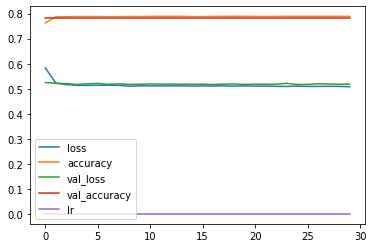

In [29]:
# To check on plot :(
pd.DataFrame(Pehleyfithoja.history).plot()

In [30]:
correcthaikya = model.predict(Scale_test )
correcthaikya = correcthaikya.reshape(20775,)

In [31]:
correcthaikya

array([0.22481987, 0.17167762, 0.19556314, ..., 0.17193419, 0.2675004 ,
       0.18704095], dtype=float32)

In [32]:
# Finally

sample['failure'] = correcthaikya
sample.to_csv('submission.csv', index=False)

# Pls Vote, Comment......aur ...share heheheeh